# Hurricane Damage Detector

## Get and Load Dataset

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14951 sha256=46573867d9df0bd5bfb60919ed40d575fb1d2310c066ce601ea60182f3c3f5a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-jx6qufcs/wheels/3d/ec/b0/a96d1d126183f98570a785e6bf8789fca559853a9260e928e1
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
!gdown --id 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:00<00:00, 73.5MB/s]


In [ ]:
!unzip -q hurricane_detector.zip

In [ ]:
ls -l

total 38748
-rw-r--r-- 1 root root 39662128 Jun 28 09:51 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 Jun 15 13:42 sample_data/
drwxr-xr-x 4 root root     4096 Jun 28 09:51 test_hurricane/
drwxr-xr-x 4 root root     4096 Jun 28 09:51 train_hurricane/


In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (91.4 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure:

In [ ]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage [655 entries exceeds filelimit, not opening dir]
└── no_damage [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [ ]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage [5895 entries exceeds filelimit, not opening dir]
└── no_damage [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Load Dependencies

In [ ]:
import keras
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras import datasets, layers, models
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import model_to_dot
from keras.layers import BatchNormalization
import tensorflow as tf
from IPython.display import SVG
tf.random.set_seed(42)

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import preprocess_input

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.8.2


## Utility functions to create dataset generators

In [ ]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    # train_ds = train_ds.prefetch(buffer_size=25)
    train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                        .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10, 
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


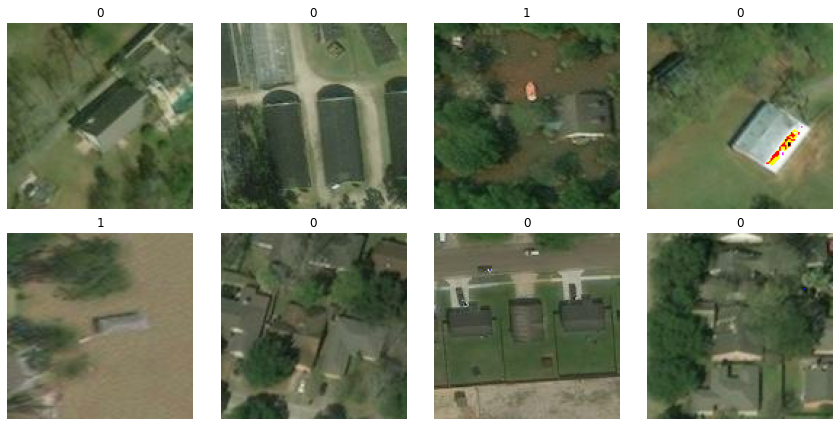

In [ ]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

In [ ]:
img_paths=[]
img_labels=[]
for i in glob('/content/train_hurricane/**',recursive=True):
    if i.endswith('.jpeg'):
        a=i.split('/')
        img_paths.append(i)
        img_labels.append(a[-2])


In [ ]:
len(img_paths),len(img_labels)

(1358, 1358)

In [ ]:
img_path = pd.Series(img_paths).astype(str)
labels=pd.Series(img_labels)
data = pd.concat([img_path,labels],axis=1)
data.sample(5)

,0,1
775,/content/train_hurricane/no_damage/-95.6353599...,no_damage
534,/content/train_hurricane/damage/-95.604431_29....,damage
1167,/content/train_hurricane/no_damage/-95.656689_...,no_damage
1044,/content/train_hurricane/no_damage/-96.9795810...,no_damage
26,/content/train_hurricane/damage/-95.601421_29....,damage


In [ ]:
# store model scores
scores = {} 

Basic CNN model

In [ ]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE),
  layers.Conv2D(16, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=20,
                                      restore_best_weights=True,
                                      verbose=1)

history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    callbacks=[es], 
                    epochs=100,
                    verbose=1
                  )

Epoch 1/100
34/34 [==============================] - 24s 50ms/step - loss: 0.6836 - accuracy: 0.5382 - val_loss: 0.6479 - val_accuracy: 0.5609
Epoch 2/100
34/34 [==============================] - 2s 25ms/step - loss: 0.6575 - accuracy: 0.5787 - val_loss: 0.6088 - val_accuracy: 0.7675
Epoch 3/100
34/34 [==============================] - 2s 25ms/step - loss: 0.6358 - accuracy: 0.6109 - val_loss: 0.6042 - val_accuracy: 0.7675
Epoch 4/100
34/34 [==============================] - 2s 26ms/step - loss: 0.6563 - accuracy: 0.5980 - val_loss: 0.6020 - val_accuracy: 0.5978
Epoch 5/100
34/34 [==============================] - 3s 43ms/step - loss: 0.6236 - accuracy: 0.6247 - val_loss: 0.5676 - val_accuracy: 0.6937
Epoch 6/100
34/34 [==============================] - 2s 22ms/step - loss: 0.6033 - accuracy: 0.6826 - val_loss: 0.5514 - val_accuracy: 0.7417
Epoch 7/100
34/34 [==============================] - 1s 18ms/step - loss: 0.5826 - accuracy: 0.6734 - val_loss: 0.5488 - val_accuracy: 0.8044
Epoch

In [ ]:
def plot_loss_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

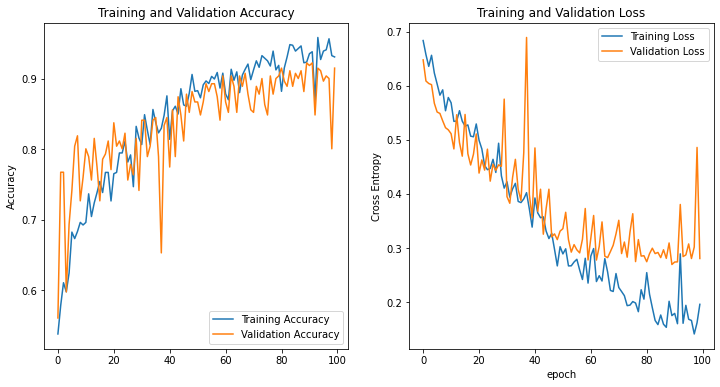

In [ ]:
plot_loss_acc(history)

In [ ]:
test_labels, predictions = eval_model_on_test(model)

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:20<00:00,  4.69it/s]


In [ ]:
predictions = np.where(predictions > 0.5, 1, 0)
cm = confusion_matrix(test_labels, predictions)
print("Classification Report:")
print(classification_report(test_labels, predictions))
print("Accuracy Score:")
print(accuracy_score(test_labels, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      6333
           1       0.89      0.83      0.86      5895

    accuracy                           0.87     12228
   macro avg       0.87      0.87      0.87     12228
weighted avg       0.87      0.87      0.87     12228

Accuracy Score:
0.8666175989532221


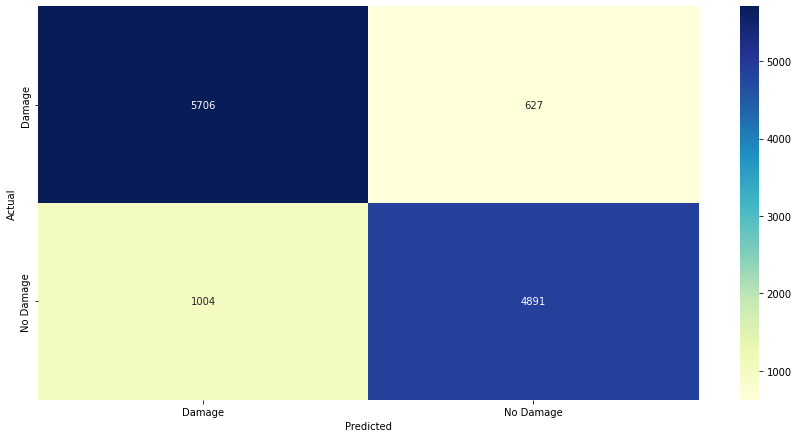

In [ ]:
classes=['Damage','No Damage']
con_mat_df = pd.DataFrame(confusion_matrix(test_labels, predictions), index = classes, columns = classes)

figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True, cmap="YlGnBu", fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
#storing the results to a dictionary
scores["Baseline_CNN"] = round(accuracy_score(test_labels, predictions), 3)

AlexNet

In [ ]:
AlexNet = keras.models.Sequential([
    #1st conv layer
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=IMG_SHAPE),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    #2nd conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    #3rd conv layer
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    #4th conv layer
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    #5th conv layer
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    #Passing it to a Fully Connected layer
    layers.Flatten(),
    #1st Fully Connected Layer
    layers.Dense(4096, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    #2nd Fully Connected Layer
    layers.Dense(4096, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    #Tried this and it caused terrible results
    # #3rd Fully Connected Layer 
    # layers.Dense(1000, activation='relu'),
    # layers.BatchNormalization(),
    # layers.Dropout(0.4),
    #Output Layer
    layers.Dense(1, activation='sigmoid')
])
AlexNet.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
AlexNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 96)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                      

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=20,
                                      restore_best_weights=True,
                                      verbose=1)
history2 = AlexNet.fit(
                    train_ds,
                    validation_data=val_ds,
                    callbacks=[es], 
                    epochs=15,
                    verbose=1
                  )

Epoch 1/15
34/34 [==============================] - 6s 64ms/step - loss: 1.0770 - accuracy: 0.4876 - recall: 0.5348 - val_loss: 0.6403 - val_accuracy: 0.7306 - val_recall: 0.5403
Epoch 2/15
34/34 [==============================] - 2s 30ms/step - loss: 0.9103 - accuracy: 0.5612 - recall: 0.5612 - val_loss: 0.6898 - val_accuracy: 0.4908 - val_recall: 0.9194
Epoch 3/15
34/34 [==============================] - 2s 27ms/step - loss: 0.8365 - accuracy: 0.6035 - recall: 0.6535 - val_loss: 0.7130 - val_accuracy: 0.4945 - val_recall: 0.9677
Epoch 4/15
34/34 [==============================] - 2s 29ms/step - loss: 0.8254 - accuracy: 0.6228 - recall: 0.6573 - val_loss: 0.7004 - val_accuracy: 0.5092 - val_recall: 0.9839
Epoch 5/15
34/34 [==============================] - 2s 27ms/step - loss: 0.8211 - accuracy: 0.6256 - recall: 0.6441 - val_loss: 0.6489 - val_accuracy: 0.5867 - val_recall: 0.9435
Epoch 6/15
34/34 [==============================] - 2s 31ms/step - loss: 0.7559 - accuracy: 0.6762 - reca

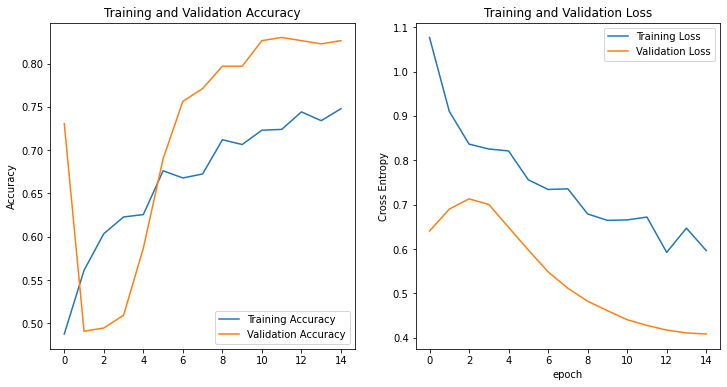

In [ ]:
plot_loss_acc(history2)

In [ ]:
test_labels2, predictions2 = eval_model_on_test(AlexNet)

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:20<00:00,  4.69it/s]


In [ ]:
predictions2 = np.where(predictions2 > 0.5, 1, 0)
cm2 = confusion_matrix(test_labels2, predictions2)
print("Classification Report:")
print(classification_report(test_labels2, predictions2))
print("Accuracy Score:")
print(accuracy_score(test_labels2, predictions2))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      6333
           1       0.80      0.79      0.80      5895

    accuracy                           0.81     12228
   macro avg       0.81      0.80      0.81     12228
weighted avg       0.81      0.81      0.81     12228

Accuracy Score:
0.8054465161923454


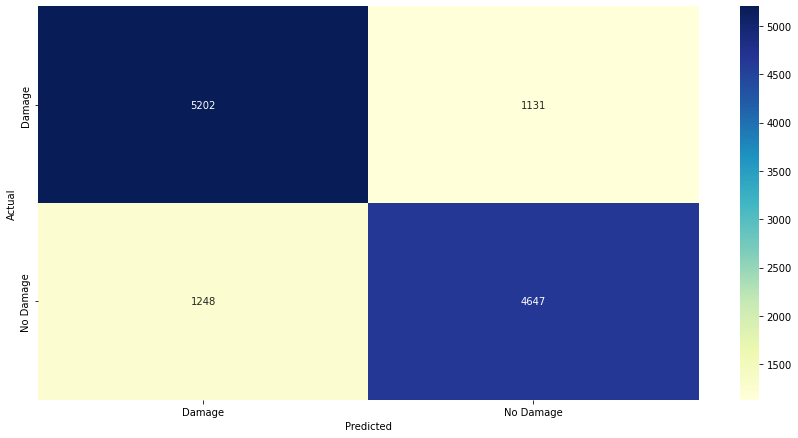

In [ ]:
con_mat_df2 = pd.DataFrame(confusion_matrix(test_labels2, predictions2), index = classes, columns = classes)

figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df2, annot=True, cmap="YlGnBu", fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
scores["AlexNet"] = round(accuracy_score(test_labels, predictions), 3)

VGG16

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = layers.Flatten(name="flatten")(top_model)
    top_model = layers.Dense(4096, activation='relu')(top_model)
    top_model = layers.Dense(1072, activation='relu')(top_model)
    top_model = layers.Dense(512, activation='relu')(top_model)
    top_model = layers.Dropout(0.2)(top_model)
    # output_layer = layers.Dense(n_classes, activation='softmax')(top_model)
    #changed it to sigmoid because if our dataset
    output_layer = layers.Dense(1, activation='sigmoid')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
n_classes= 1
optim = optimizer=tf.optimizers.Adam(lr=0.001)

n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(IMG_SHAPE, n_classes, optim, fine_tune=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=20,
                                      restore_best_weights=True,
                                      mode='min',
                                      verbose=1)
vgg_history = vgg_model.fit(
                    train_ds,
                    batch_size=BATCH_SIZE,
                    validation_data=val_ds,
                    callbacks=[es], 
                    epochs=n_epochs,
                    verbose=1
                  )

Epoch 1/50
34/34 [==============================] - 9s 159ms/step - loss: 4.1852 - accuracy: 0.7755 - val_loss: 0.6464 - val_accuracy: 0.8524
Epoch 2/50
34/34 [==============================] - 4s 90ms/step - loss: 0.3609 - accuracy: 0.8924 - val_loss: 0.3616 - val_accuracy: 0.8856
Epoch 3/50
34/34 [==============================] - 3s 75ms/step - loss: 0.1746 - accuracy: 0.9374 - val_loss: 0.5333 - val_accuracy: 0.8782
Epoch 4/50
34/34 [==============================] - 3s 76ms/step - loss: 0.1451 - accuracy: 0.9503 - val_loss: 0.3928 - val_accuracy: 0.8782
Epoch 5/50
34/34 [==============================] - 3s 76ms/step - loss: 0.0652 - accuracy: 0.9742 - val_loss: 0.6710 - val_accuracy: 0.8819
Epoch 6/50
34/34 [==============================] - 4s 93ms/step - loss: 0.1006 - accuracy: 0.9715 - val_loss: 0.3546 - val_accuracy: 0.8930
Epoch 7/50
34/34 [==============================] - 4s 85ms/step - loss: 0.0616 - accuracy: 0.9788 - val_loss: 0.4943 - val_accuracy: 0.8782
Epoch 8/50
3

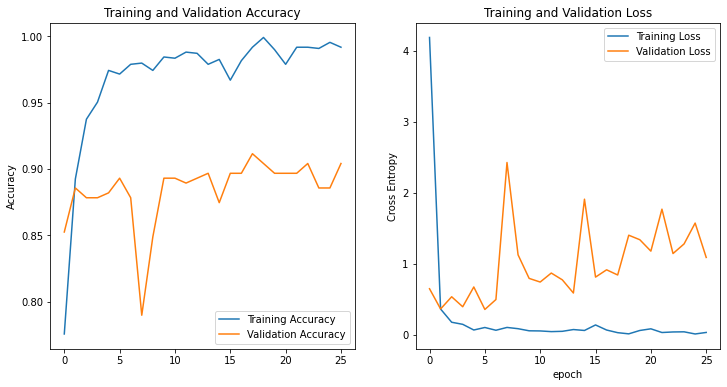

In [ ]:
plot_loss_acc(vgg_history)

In [ ]:
test_labels3, predictions3 = eval_model_on_test(vgg_model)

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:40<00:00,  2.34it/s]


In [ ]:
predictions3 = np.where(predictions3 > 0.5, 1, 0)
cm3 = confusion_matrix(test_labels3, predictions3)
print("Classification Report:")
print(classification_report(test_labels3, predictions3))
print("Accuracy Score:")
print(accuracy_score(test_labels3, predictions3))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      6333
           1       0.93      0.89      0.91      5895

    accuracy                           0.91     12228
   macro avg       0.91      0.91      0.91     12228
weighted avg       0.91      0.91      0.91     12228

Accuracy Score:
0.913804383382401


In [ ]:
con_mat_df3 = pd.DataFrame(confusion_matrix(test_labels3, predictions3), index = classes, columns = classes)

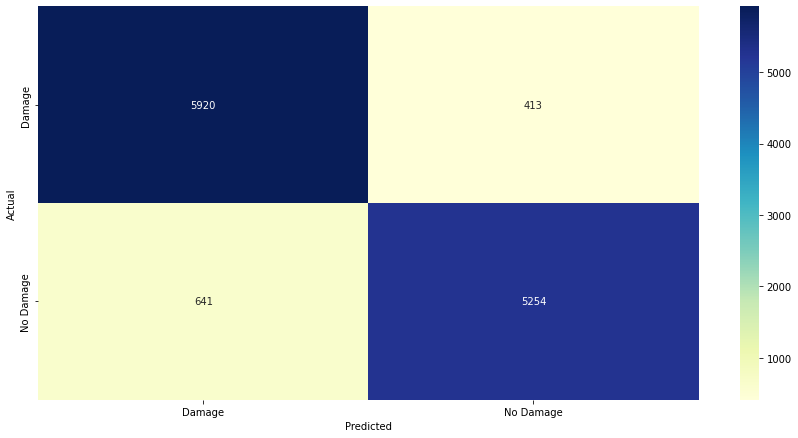

In [ ]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df3, annot=True, cmap="YlGnBu", fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
scores["vgg16"] = round(accuracy_score(test_labels3, predictions3), 3)

Finetune VGG16

In [ ]:
optim2 = optimizer=tf.optimizers.Adam(lr=0.0001)

vgg_model_ft = create_model(IMG_SHAPE, n_classes, optim2, fine_tune=2)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
vgg_model_ft.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
vgg_ft_history = vgg_model_ft.fit(train_ds,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=val_ds,
                                  callbacks=[es], 
                                  verbose=1)

Epoch 1/50
34/34 [==============================] - 7s 111ms/step - loss: 1.3416 - accuracy: 0.7902 - val_loss: 0.4526 - val_accuracy: 0.8893
Epoch 2/50
34/34 [==============================] - 4s 86ms/step - loss: 0.2292 - accuracy: 0.9292 - val_loss: 0.3578 - val_accuracy: 0.8930
Epoch 3/50
34/34 [==============================] - 4s 84ms/step - loss: 0.1111 - accuracy: 0.9586 - val_loss: 0.3398 - val_accuracy: 0.9041
Epoch 4/50
34/34 [==============================] - 4s 85ms/step - loss: 0.0915 - accuracy: 0.9779 - val_loss: 0.3234 - val_accuracy: 0.9225
Epoch 5/50
34/34 [==============================] - 3s 81ms/step - loss: 0.0428 - accuracy: 0.9816 - val_loss: 0.4381 - val_accuracy: 0.9077
Epoch 6/50
34/34 [==============================] - 4s 88ms/step - loss: 0.0614 - accuracy: 0.9770 - val_loss: 0.4185 - val_accuracy: 0.9077
Epoch 7/50
34/34 [==============================] - 4s 90ms/step - loss: 0.0751 - accuracy: 0.9752 - val_loss: 0.4607 - val_accuracy: 0.9114
Epoch 8/50
3

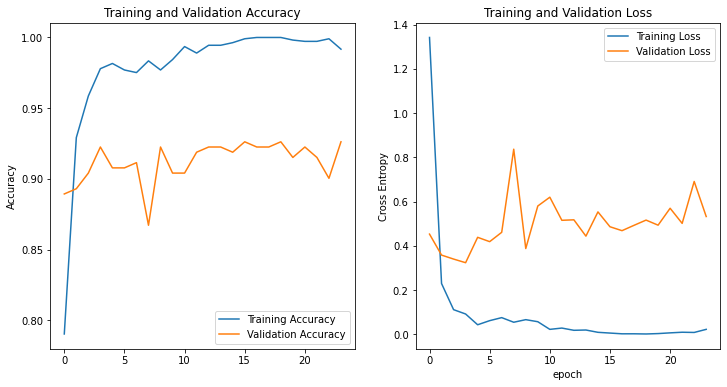

In [ ]:
plot_loss_acc(vgg_ft_history)

In [ ]:
test_labels4, predictions4 = eval_model_on_test(vgg_model_ft)

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:36<00:00,  2.62it/s]


In [ ]:
predictions4 = np.where(predictions4 > 0.5, 1, 0)
cm4 = confusion_matrix(test_labels4, predictions4)
print("Classification Report:")
print(classification_report(test_labels4, predictions4))
print("Accuracy Score:")
print(accuracy_score(test_labels4, predictions4))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      6333
           1       0.94      0.86      0.90      5895

    accuracy                           0.91     12228
   macro avg       0.91      0.91      0.91     12228
weighted avg       0.91      0.91      0.91     12228

Accuracy Score:
0.9099607458292444


In [ ]:
con_mat_df4 = pd.DataFrame(confusion_matrix(test_labels4, predictions4), index = classes, columns = classes)

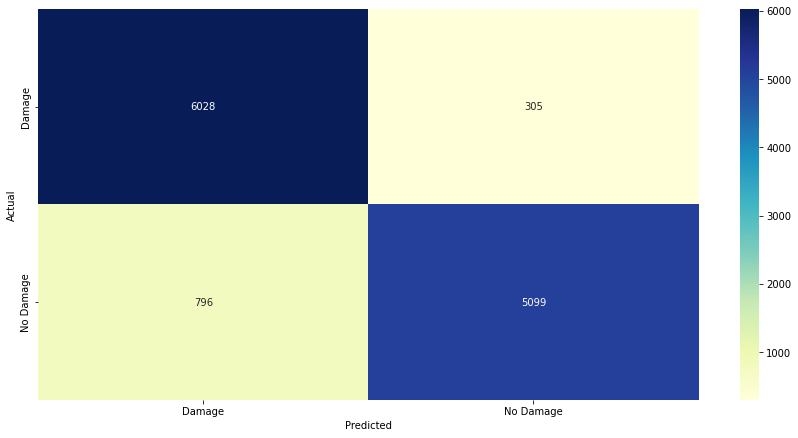

In [ ]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df4, annot=True, cmap="YlGnBu", fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
scores["vgg_tuned"] = round(accuracy_score(test_labels4, predictions4), 3)

Resnet50

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(128,128, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x, training=False)  # important: training=False
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_resnet = tf.keras.Model(inputs, outputs)

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model_resnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               5245

In [ ]:
history_resnet = model_resnet.fit(
                    train_ds,
                    validation_data=val_ds,
                    callbacks=[es], 
                    epochs=30,
                    verbose=1
                  )

Epoch 1/30
34/34 [==============================] - 10s 143ms/step - loss: 0.7666 - accuracy: 0.6799 - val_loss: 0.3135 - val_accuracy: 0.8708
Epoch 2/30
34/34 [==============================] - 3s 59ms/step - loss: 0.3590 - accuracy: 0.8740 - val_loss: 0.2537 - val_accuracy: 0.9077
Epoch 3/30
34/34 [==============================] - 3s 59ms/step - loss: 0.2942 - accuracy: 0.8979 - val_loss: 0.2532 - val_accuracy: 0.9077
Epoch 4/30
34/34 [==============================] - 3s 58ms/step - loss: 0.2540 - accuracy: 0.9052 - val_loss: 0.2134 - val_accuracy: 0.9225
Epoch 5/30
34/34 [==============================] - 3s 58ms/step - loss: 0.2346 - accuracy: 0.9089 - val_loss: 0.2093 - val_accuracy: 0.9225
Epoch 6/30
34/34 [==============================] - 3s 56ms/step - loss: 0.2127 - accuracy: 0.9227 - val_loss: 0.2195 - val_accuracy: 0.9151
Epoch 7/30
34/34 [==============================] - 3s 66ms/step - loss: 0.1823 - accuracy: 0.9282 - val_loss: 0.2040 - val_accuracy: 0.9299
Epoch 8/30


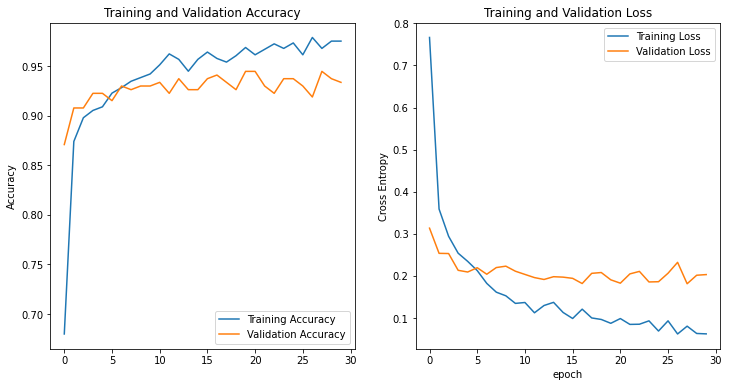

In [ ]:
plot_loss_acc(history_resnet)

In [ ]:
test_labels_res, predictions_res = eval_model_on_test(model_resnet)

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:32<00:00,  2.95it/s]


In [ ]:
predictions_res = np.where(predictions_res > 0.5, 1, 0)
cm_res = confusion_matrix(test_labels_res, predictions_res)
print("Classification Report:")
print(classification_report(test_labels_res, predictions_res))
print("Accuracy Score:")
print(accuracy_score(test_labels_res, predictions_res))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      6333
           1       0.95      0.92      0.94      5895

    accuracy                           0.94     12228
   macro avg       0.94      0.94      0.94     12228
weighted avg       0.94      0.94      0.94     12228

Accuracy Score:
0.9387471377167157


In [ ]:
con_matres_df = pd.DataFrame(confusion_matrix(test_labels_res, predictions_res), index = classes, columns = classes)

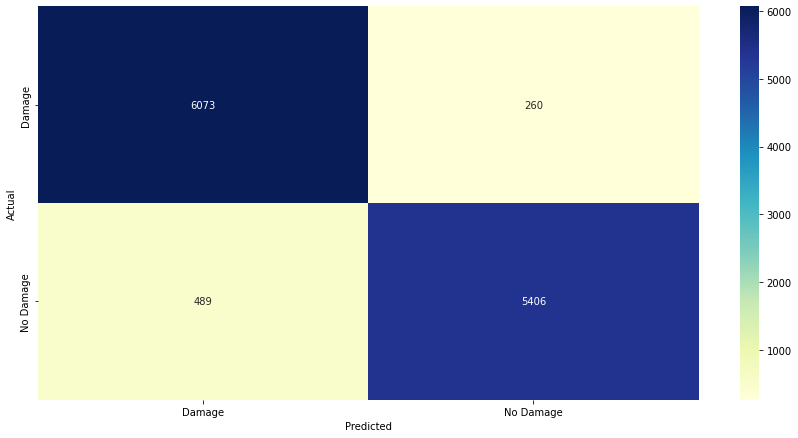

In [ ]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_matres_df, annot=True, cmap="YlGnBu", fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
scores["resnet_50"] = round(accuracy_score(test_labels_res, predictions_res), 3)

Resnet50 tuned

In [62]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

LR = 0.0001/10
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy'])

In [63]:
model_resnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               5245

In [64]:
fine_tune_epochs = 100
total_epochs =  30 + fine_tune_epochs

history_resnet_ft = model_resnet.fit(
                    train_ds,
                    validation_data=val_ds,
                    callbacks=[es], 
                    initial_epoch = history_resnet.epoch[-1],
                    epochs=total_epochs,
                    verbose=1
                  )

Epoch 30/130
34/34 [==============================] - 16s 201ms/step - loss: 0.0800 - accuracy: 0.9706 - val_loss: 0.1836 - val_accuracy: 0.9594
Epoch 31/130
34/34 [==============================] - 4s 95ms/step - loss: 0.0528 - accuracy: 0.9770 - val_loss: 0.1699 - val_accuracy: 0.9483
Epoch 32/130
34/34 [==============================] - 4s 93ms/step - loss: 0.0444 - accuracy: 0.9834 - val_loss: 0.1612 - val_accuracy: 0.9520
Epoch 33/130
34/34 [==============================] - 4s 89ms/step - loss: 0.0517 - accuracy: 0.9825 - val_loss: 0.2038 - val_accuracy: 0.9410
Epoch 34/130
34/34 [==============================] - 4s 100ms/step - loss: 0.0334 - accuracy: 0.9917 - val_loss: 0.1820 - val_accuracy: 0.9520
Epoch 35/130
34/34 [==============================] - 5s 107ms/step - loss: 0.0124 - accuracy: 0.9991 - val_loss: 0.1859 - val_accuracy: 0.9446
Epoch 36/130
34/34 [==============================] - 5s 103ms/step - loss: 0.0238 - accuracy: 0.9926 - val_loss: 0.1899 - val_accuracy: 0

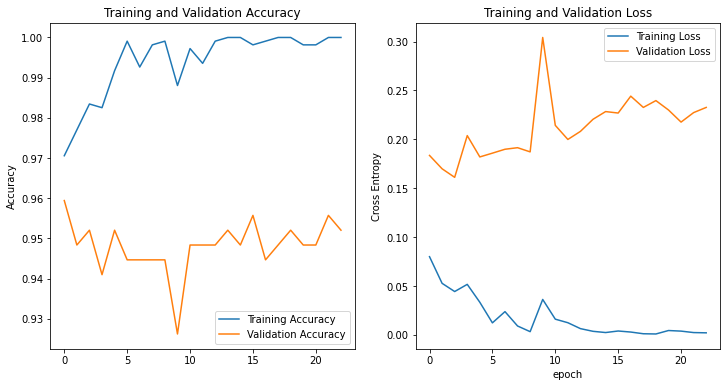

In [65]:
plot_loss_acc(history_resnet_ft)

In [66]:
test_labels_res_ft, predictions_res_ft = eval_model_on_test(model_resnet)

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:40<00:00,  2.34it/s]


In [67]:
predictions_res_ft = np.where(predictions_res_ft > 0.5, 1, 0)
cm_res_ft = confusion_matrix(test_labels_res_ft, predictions_res_ft)
print("Classification Report:")
print(classification_report(test_labels_res_ft, predictions_res_ft))
print("Accuracy Score:")
print(accuracy_score(test_labels_res_ft, predictions_res_ft))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6333
           1       0.94      0.94      0.94      5895

    accuracy                           0.95     12228
   macro avg       0.95      0.95      0.95     12228
weighted avg       0.95      0.95      0.95     12228

Accuracy Score:
0.9452894995093228


In [68]:
con_matres_ft_df = pd.DataFrame(confusion_matrix(test_labels_res_ft, predictions_res_ft), index = classes, columns = classes)

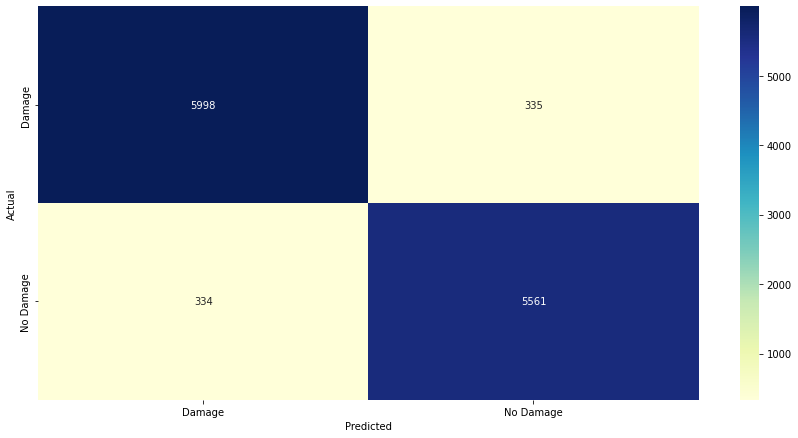

In [69]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_matres_ft_df, annot=True, cmap="YlGnBu", fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [70]:
scores["resnet_50_fine_tuning"] = round(accuracy_score(test_labels_res_ft, predictions_res_ft), 3)

Resnet 50 finetuning + decaying leaning rate

In [71]:
initial_learning_rate =  0.00001
final_learning_rate = initial_learning_rate/10
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/fine_tune_epochs)
steps_per_epoch = int(10000/32)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [72]:
model_resnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               5245

In [73]:
history_r50_ftd = model_resnet.fit(
                    train_ds,
                    validation_data=val_ds,
                    callbacks=[es], 
                    initial_epoch = history_resnet.epoch[-1],
                    epochs=total_epochs,
                    verbose=1
                  )

Epoch 30/130
34/34 [==============================] - 9s 126ms/step - loss: 0.0225 - accuracy: 0.9926 - val_loss: 0.2882 - val_accuracy: 0.9225
Epoch 31/130
34/34 [==============================] - 4s 94ms/step - loss: 0.0234 - accuracy: 0.9917 - val_loss: 0.2199 - val_accuracy: 0.9483
Epoch 32/130
34/34 [==============================] - 4s 91ms/step - loss: 0.0243 - accuracy: 0.9899 - val_loss: 0.2225 - val_accuracy: 0.9446
Epoch 33/130
34/34 [==============================] - 4s 94ms/step - loss: 0.0216 - accuracy: 0.9926 - val_loss: 0.2197 - val_accuracy: 0.9446
Epoch 34/130
34/34 [==============================] - 5s 113ms/step - loss: 0.0180 - accuracy: 0.9945 - val_loss: 0.2176 - val_accuracy: 0.9557
Epoch 35/130
34/34 [==============================] - 5s 105ms/step - loss: 0.0084 - accuracy: 0.9963 - val_loss: 0.2112 - val_accuracy: 0.9594
Epoch 36/130
34/34 [==============================] - 5s 106ms/step - loss: 0.0161 - accuracy: 0.9926 - val_loss: 0.1868 - val_accuracy: 0.

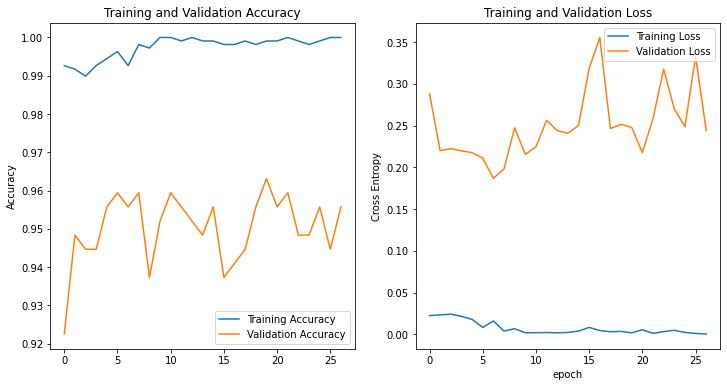

In [74]:
plot_loss_acc(history_r50_ftd)

In [75]:
test_labels_res_ftd, predictions_res_ftd = eval_model_on_test(model_resnet)

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:40<00:00,  2.34it/s]


In [76]:
predictions_res_ftd = np.where(predictions_res_ftd > 0.5, 1, 0)
cm_res_ftd = confusion_matrix(test_labels_res_ftd, predictions_res_ftd)
print("Classification Report:")
print(classification_report(test_labels_res_ftd, predictions_res_ftd))
print("Accuracy Score:")
print(accuracy_score(test_labels_res_ftd, predictions_res_ftd))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6333
           1       0.97      0.92      0.95      5895

    accuracy                           0.95     12228
   macro avg       0.95      0.95      0.95     12228
weighted avg       0.95      0.95      0.95     12228

Accuracy Score:
0.9487242394504416


In [77]:
con_matres_ftd_df = pd.DataFrame(confusion_matrix(test_labels_res_ftd, predictions_res_ftd), index = classes, columns = classes)

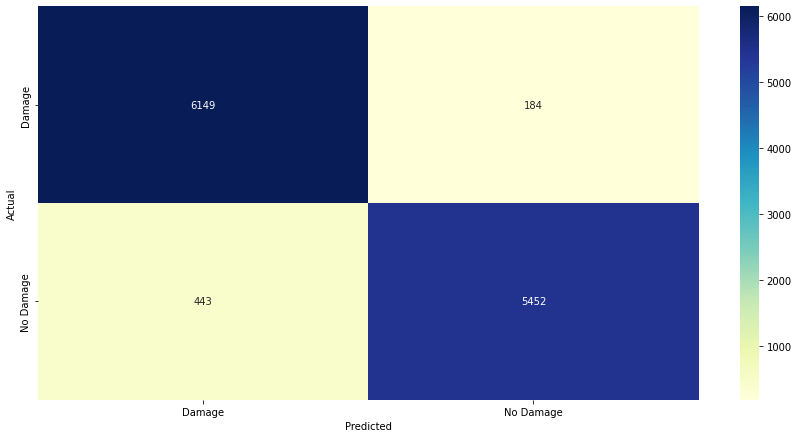

In [78]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_matres_ftd_df, annot=True, cmap="YlGnBu", fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [79]:
scores["resnet_50_finetuning_DecayingLR"] = round(accuracy_score(test_labels_res_ftd, predictions_res_ftd), 3)

MobileNet

In [80]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model_mobilenet = tf.keras.Model(inputs, outputs)

model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy'])

9420800/9406464 [==============================] - 0s 0us/step


In [81]:
model_mobilenet.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [82]:
history_mobilenet = model_mobilenet.fit(
                                        train_ds,
                                        validation_data=val_ds,
                                        callbacks=[es], 
                                        epochs=50,
                                        verbose=1
                                      )

Epoch 1/50
34/34 [==============================] - 6s 67ms/step - loss: 6.0004 - accuracy: 0.4940 - val_loss: 5.0684 - val_accuracy: 0.5129
Epoch 2/50
34/34 [==============================] - 2s 29ms/step - loss: 5.0047 - accuracy: 0.5474 - val_loss: 4.5484 - val_accuracy: 0.5461
Epoch 3/50
34/34 [==============================] - 2s 28ms/step - loss: 5.1784 - accuracy: 0.5667 - val_loss: 3.8683 - val_accuracy: 0.5572
Epoch 4/50
34/34 [==============================] - 2s 26ms/step - loss: 4.9875 - accuracy: 0.5511 - val_loss: 3.9296 - val_accuracy: 0.5941
Epoch 5/50
34/34 [==============================] - 3s 42ms/step - loss: 4.6725 - accuracy: 0.5906 - val_loss: 4.2847 - val_accuracy: 0.5904
Epoch 6/50
34/34 [==============================] - 2s 33ms/step - loss: 5.1235 - accuracy: 0.5667 - val_loss: 3.9184 - val_accuracy: 0.6052
Epoch 7/50
34/34 [==============================] - 2s 35ms/step - loss: 4.9294 - accuracy: 0.5667 - val_loss: 3.8382 - val_accuracy: 0.6310
Epoch 8/50
34

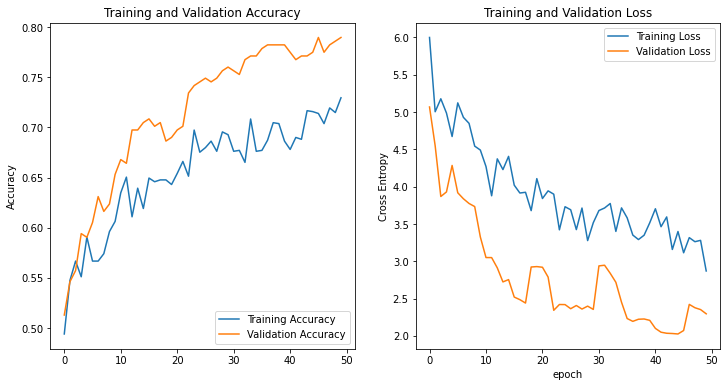

In [83]:
plot_loss_acc(history_mobilenet)

In [84]:
test_labels_mn, predictions_mn = eval_model_on_test(model_mobilenet)

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:40<00:00,  2.34it/s]


In [85]:
predictions_mn = np.where(predictions_mn > 0.5, 1, 0)
cm_mn = confusion_matrix(test_labels_mn, predictions_mn)
print("Classification Report:")
print(classification_report(test_labels_mn, predictions_mn))
print("Accuracy Score:")
print(accuracy_score(test_labels_mn, predictions_mn))

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      6333
           1       0.84      0.65      0.73      5895

    accuracy                           0.77     12228
   macro avg       0.79      0.77      0.77     12228
weighted avg       0.78      0.77      0.77     12228

Accuracy Score:
0.771099116781158


In [86]:
con_matmn_df = pd.DataFrame(confusion_matrix(test_labels_mn, predictions_mn), index = classes, columns = classes)

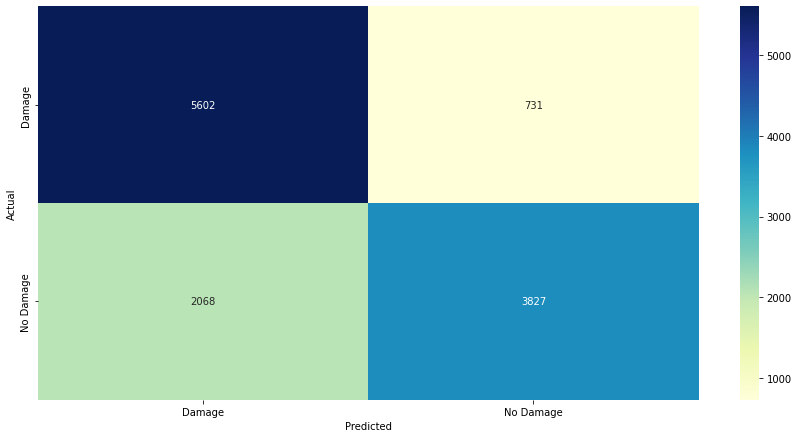

In [87]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_matmn_df, annot=True, cmap="YlGnBu", fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [88]:
scores["Mobile_net"] = round(accuracy_score(test_labels_res, predictions_res), 3)

Scores

In [96]:
df = pd.DataFrame(scores, index=[0])
df = df.T 
df.rename(columns={0: "accuracy"}).sort_values(by="accuracy",ascending=False)

,accuracy
resnet_50_finetuning_DecayingLR,0.949
resnet_50_fine_tuning,0.945
resnet_50,0.939
Mobile_net,0.939
vgg16,0.914
vgg_tuned,0.910
Baseline_CNN,0.867
AlexNet,0.867


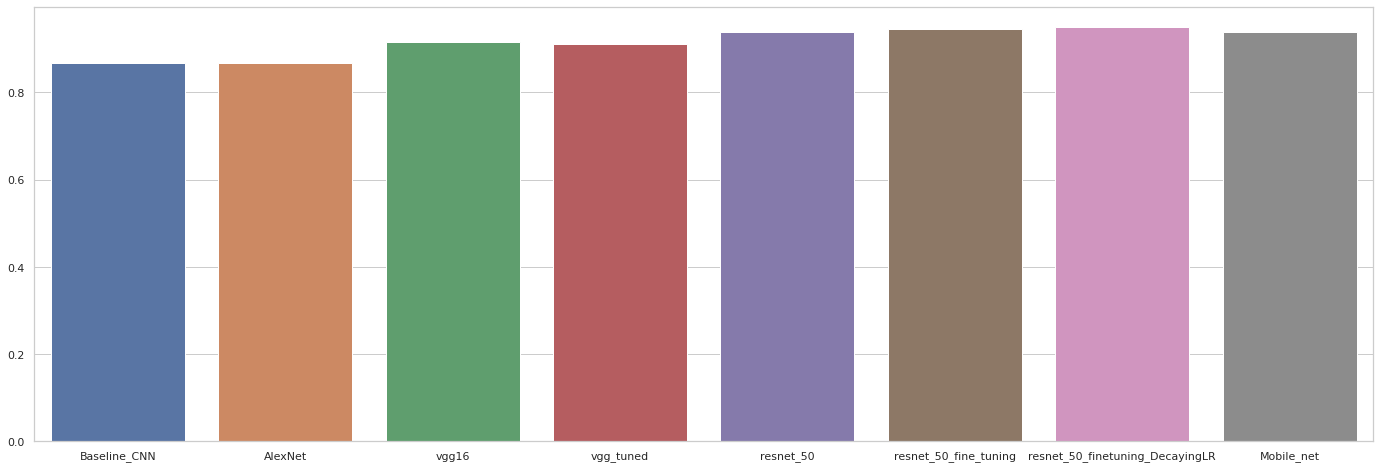

In [105]:
plt.figure(figsize=(24, 8))
sns.set_theme(style="whitegrid")
sns.barplot(x=list(scores.keys()),
            y=list(scores.values()));